In [10]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import save_image

from PIL import Image
from tqdm import tqdm

from models import simpleAE, simpleAEsmaller, simpleAEevenSmaller, simpleAEevenSmallerWithUpsampling, noBatchNormModel

from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = "album_covers_512"
batch_size = 8
img_size = 256

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img  # no labels


In [4]:
dataset = ImageDataset(data_dir, transform=transform)

small_subset = Subset(dataset, range(batch_size))
test_small_subset = Subset(dataset, range(batch_size, 2 * batch_size))

small_dl = DataLoader(small_subset, batch_size=batch_size, shuffle=True, drop_last=True)
small_test_dl = DataLoader(test_small_subset, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
def break_img(img, size=32, fill=0.0, cords = None):
    device = img.device
    img = img.clone()  # avoid modifying the original tensor

    _, w, h = img.shape
    max_start = min(w, h) - size - 1

    if cords is None:
        beg_w = torch.randint(1, max_start, (1,)).item()
        beg_h = torch.randint(1, max_start, (1,)).item()
    else:
        beg_w, beg_h = cords

    mask = torch.zeros((w, h), dtype=torch.bool, device=device)

    mask[beg_w: beg_w + size, beg_h: beg_h + size] = True

    img[:, mask] = fill

    mask = mask.unsqueeze(dim=0).float()

    return torch.cat([img, mask])

def break_batch(imgs, size=32, fill=0.0, amount = 4, cords = None):
    # if cords is None, patch location is randomized every time
    B = imgs.shape[0]

    corr_imgs = []
    break_coords = []

    for i in range(B):
        img = imgs[i]
        if cords is None:
            for j in range(amount):
                img = break_img(img, size=size, fill=fill)
        else:
            for cord in cords[i]:
                img = break_img(img, size = size, fill = fill, cords = cord)
        corr_imgs.append(img)

    corr_imgs = torch.stack(corr_imgs, dim=0)
    rgb = corr_imgs[:, :3]
    merged = corr_imgs[:, 3:].any(dim=1, keepdim=True).float()
    corr_imgs = torch.cat([rgb, merged], dim=1)
    return corr_imgs


In [5]:
def fix_image_naive_1(img, beg_w, beg_h, size = 32, biased = True):
    strong_weight = 0.5 if biased else 0.34
    weak_weight = 0.25 if biased else 0.33
    for i in range(size):
        #UPPER
        img[beg_w + i, beg_h, :] = strong_weight * img[beg_w + i, beg_h - 1, :] + weak_weight * img[beg_w + i - 1, beg_h - 1, :] + weak_weight * img[beg_w + i + 1, beg_h - 1, :]

        #BOTTOM
        img[beg_w + i, beg_h + size - 1, :] = strong_weight * img[beg_w + i, beg_h + size, :] + weak_weight * img[beg_w + i - 1, beg_h + size, :] + weak_weight * img[beg_w + i + 1, beg_h + size, :]

        #LEFT
        img[beg_w, beg_h + i, :] = strong_weight * img[beg_w -1, beg_h + i, :] + weak_weight * img[beg_w - 1, beg_h + i - 1, :] + weak_weight * img[beg_w - 1, beg_h + i + 1, :]

        #RIGHT
        img[beg_w + size - 1, beg_h + i, :] = strong_weight * img[beg_w + size, beg_h + i, :] + weak_weight * img[beg_w + size, beg_h + i - 1, :] + weak_weight * img[beg_w + size, beg_h + i + 1, :]
    
    if size > 0:
        fix_image_naive_1(img, beg_w + 1, beg_h + 1, size - 2)

In [7]:
def gaussian_approach(img):
    0

In [21]:
images = next(iter(small_dl))
images_test = next(iter(small_test_dl))

[(16, 103), (103, 124), (14, 125), (75, 51), (70, 98), (185, 102), (152, 167), (71, 140)]


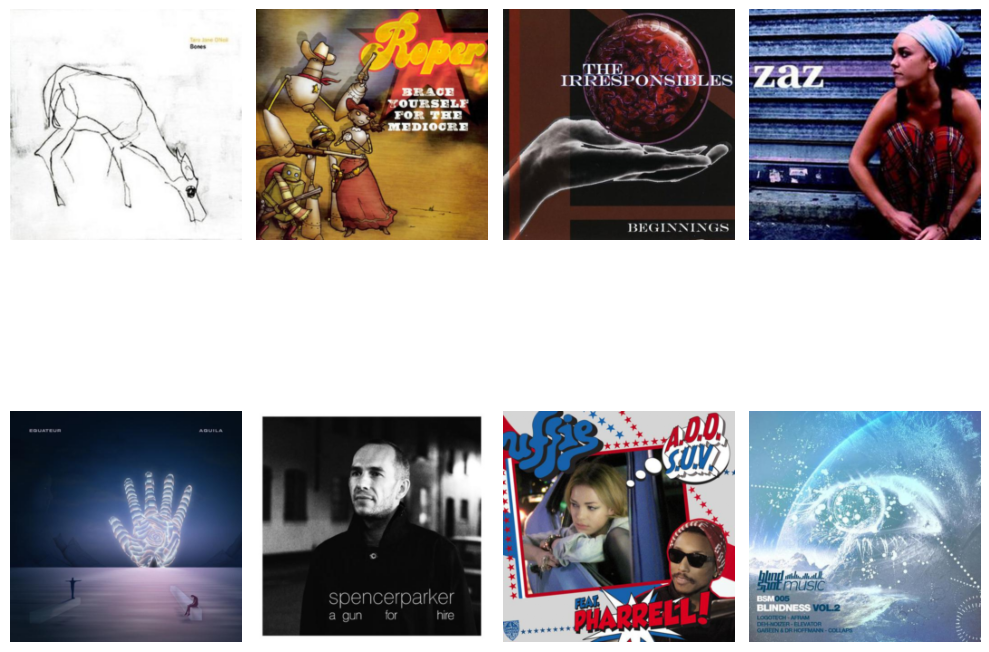

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

cords = [(np.random.randint(0, 256 - 64), np.random.randint(0, 256 - 64)) for _ in range(batch_size)]
print(cords)

for i, ax in enumerate(axes):   
    img = images_test[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

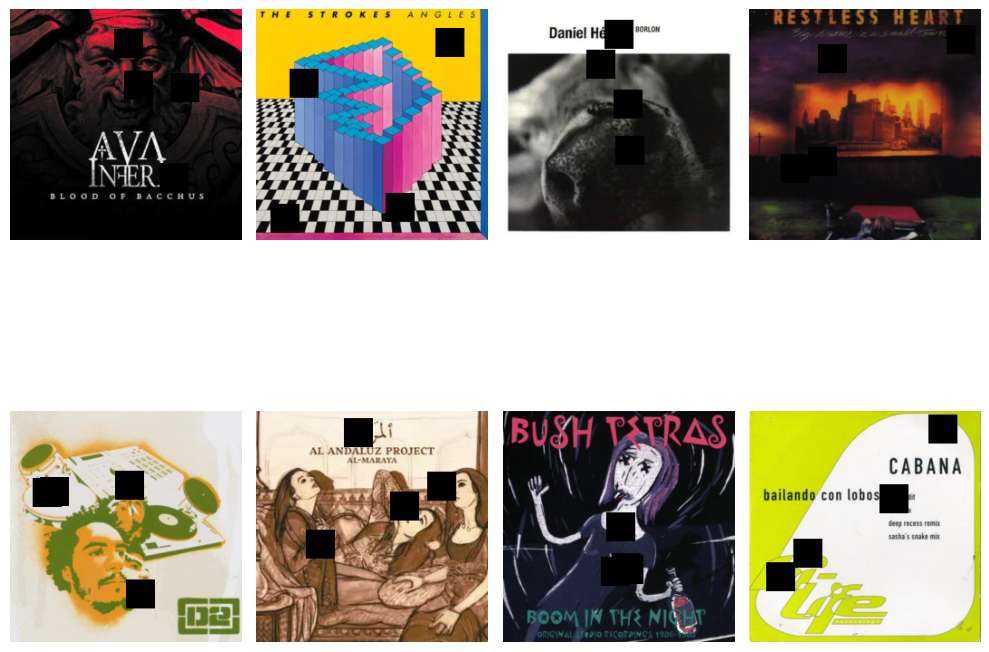

In [31]:
images_corr_w_masks = break_batch(images)
images_corr = images_corr_w_masks[:, 0:3, :, :]
masks = images_corr_w_masks[:, 3, :, :]

fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):   
    img = np.transpose(images_corr[i], (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
        self.features = nn.Sequential(*list(vgg.features)[:16])
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x, y, mask = None):
        x = (x + 1) / 2
        y = (y + 1) / 2

        fx = self.features(x)
        fy = self.features(y)
        if mask is None:
            return F.l1_loss(fx, fy)
        mask = mask.unsqueeze(1)
        mask_resized = F.interpolate(mask, size=fx.shape[2:], mode="nearest")

        loss = torch.abs(fx - fy) * mask_resized
        loss = loss.sum() / (mask_resized.sum() + 1e-8)

        return loss
        

In [7]:
def on_patch_loss(img, recon_image, mask, use_mse = True):

    mask = mask.unsqueeze(1).detach()

    mask = mask.expand_as(recon_image) # (B, 3, W, H)
    
    if use_mse:
        diff = (recon_image - img) ** 2
    else:
        diff = torch.abs(recon_image - img)
    
    diff = diff * mask

    loss = diff.sum() / (mask.sum() + 1e-8)

    return loss

In [8]:
def masked_tv_loss(pred, mask):
    mask = mask.unsqueeze(1).detach()
    mask = mask.expand_as(pred)

    diff_h = torch.abs(pred[:, :, :, :-1] - pred[:, :, :, 1:])
    mask_h = mask[:, :, :, :-1] * mask[:, :, :, 1:]

    diff_v = torch.abs(pred[:, :, :-1, :] - pred[:, :, 1:, :])
    mask_v = mask[:, :, :-1, :] * mask[:, :, 1:, :]

    loss = (diff_h * mask_h).mean() + (diff_v * mask_v).mean()
    return loss


In [ ]:
num_epochs = 1000
DEVICE = "cuda"

cords = [tuple((np.random.randint(0, 256 - 64), np.random.randint(0, 256 - 64)) for _ in range(4)) for _ in range(batch_size)]

for modelType, model_name in [[simpleAE, "larger"] ,[simpleAEsmaller, "smaller"] ,[simpleAEevenSmaller, "evenSmaller"]]:
    for lr in [1e-4, 1e-3, 1e-2]:
        writer = SummaryWriter(log_dir=f"runs/{model_name}_w_lr_{lr}")
        model = modelType().to(DEVICE)
        model.train()


        perp = PerceptualLoss().to(DEVICE)

        optimizer = torch.optim.Adam(model.parameters(), lr)

        for epoch in tqdm(range(num_epochs)):
            total_rec = 0
            total_perc = 0
            for images in small_dl:
                images = images.to(DEVICE)
                corr_images_w_masks = break_batch(images, cords = cords)
                mask = corr_images_w_masks[:, 3, :, :]

                optimizer.zero_grad()
                
                img_repaired = model(corr_images_w_masks)

                rec_loss = on_patch_loss(images, img_repaired, mask)
                perc_loss = perp(images, img_repaired, mask)

                loss = rec_loss + (min(1, epoch / 100) * 0.1) * perc_loss

                total_perc += perc_loss
                total_rec += rec_loss
                
                loss.backward()
                optimizer.step()

            writer.add_scalar("Loss/train_perc", total_perc / len(small_dl), epoch)
            writer.add_scalar("Loss/train_rec", total_rec / len(small_dl), epoch)
            
            for name, param in model.named_parameters():
                writer.add_histogram(name, param, global_step=epoch)
                if param.grad is not None:
                    writer.add_histogram(f"{name}.grad", param.grad, epoch)
                writer.add_scalar(f"weight_norm/{name}", param.norm().item(), epoch)
                

            if ((epoch + 1) % 100 == 0):
                torch.save(model.state_dict(), f"ae_{model_name}_{lr}_{epoch+1}.pth")
                save_image(
                    img_repaired[:16],
                    f"recon_epoch_{model_name}_{lr}_{epoch+1}.png",
                    normalize = True
                )
        writer.close()

100%|██████████| 1000/1000 [11:48<00:00,  1.41it/s]


In [16]:
images_test = next(iter(test_loader))

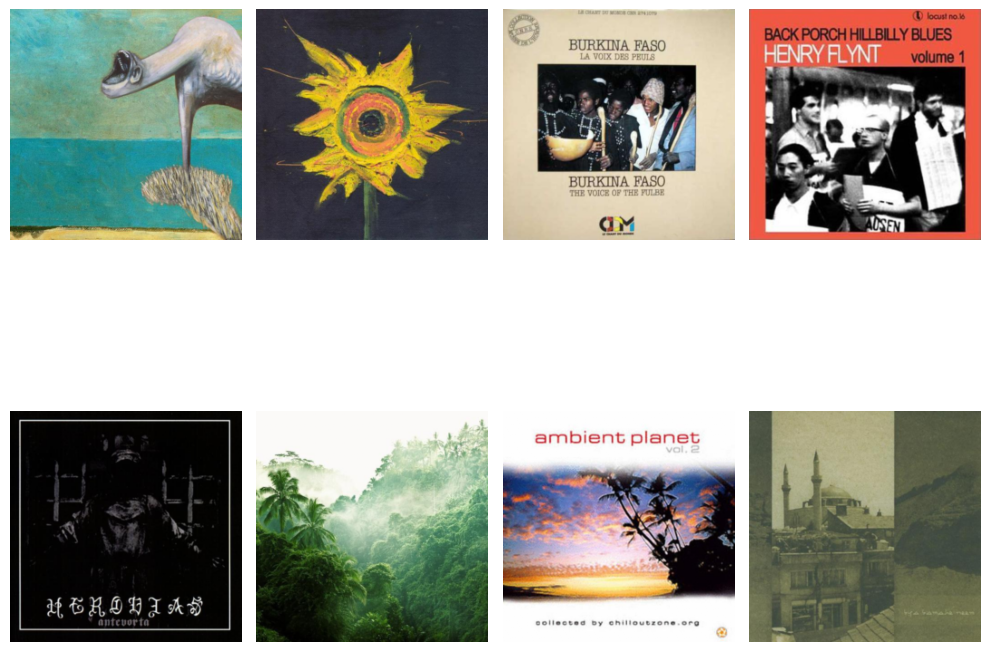

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):   
    img = np.transpose(images_test[i], (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

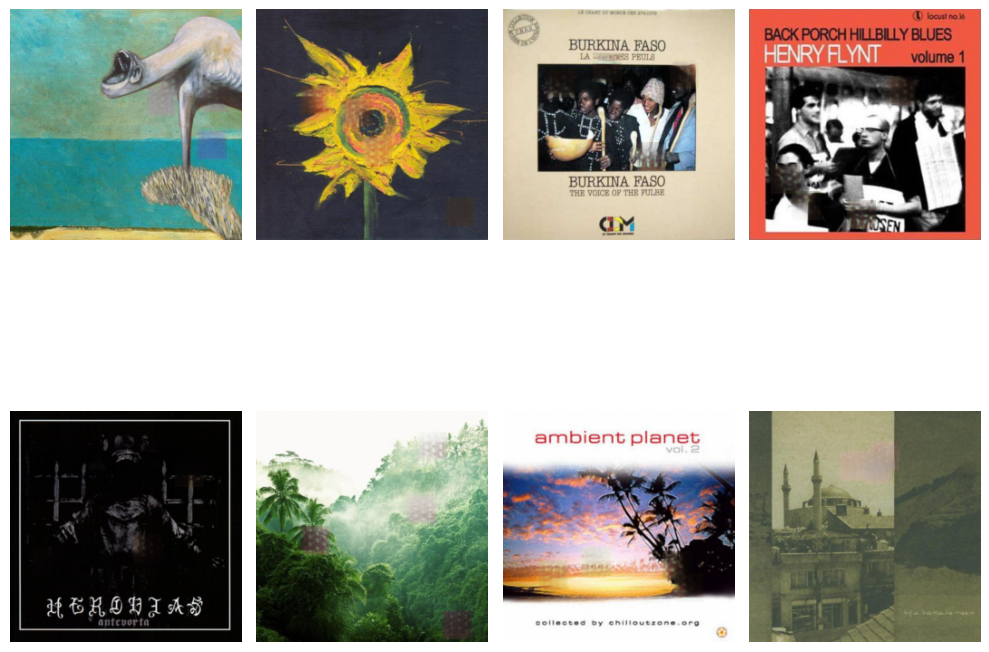

In [24]:
model = noBatchNormModel().to(DEVICE)

model.load_state_dict(torch.load("ae_finalnet7_15.pth", weights_only=True))

model.eval()

images = images_test.to(DEVICE)

images_corr = break_batch(images)

mask = images_corr[:, 3, :, :]

with torch.no_grad():
    images_fixed = model(images_corr)


images_fixed = images_fixed.detach().cpu().numpy()
images_og = images.detach().cpu().numpy().copy()

mask = mask.detach().cpu().numpy()

fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):   
    img = np.transpose(images_fixed[i], (1, 2, 0))
    img_org = np.transpose(images_og[i], (1, 2, 0))
    curr_mask = np.repeat(mask[i, :, :, np.newaxis], 3, axis=-1)
    img = np.where(curr_mask == 1, img, img_org)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
dataset = ImageDataset(data_dir, transform=transform)
train_set, test_set = random_split(dataset, [20000, len(dataset) - 20000])

train_loader = DataLoader(train_set, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(train_set, batch_size, shuffle = False)

In [13]:
num_epochs = 20
DEVICE = "cuda"

lr = 3e-4


model = noBatchNormModel().to(DEVICE)
model.train()
writer = SummaryWriter(log_dir=f"runs/finalnet7")


perp = PerceptualLoss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr)

scaler = torch.amp.GradScaler("cuda")

for epoch in range(num_epochs):
    total_rec = 0
    total_perc = 0
    total_tv = 0
    step = 0
    for images in tqdm(train_loader):
        images = images.to(DEVICE)
        corr_images_w_masks = break_batch(images)
        mask = corr_images_w_masks[:, 3, :, :]

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
        
            img_repaired = model(corr_images_w_masks)

            rec_loss = on_patch_loss(images, img_repaired, mask, use_mse = False)
            perc_loss = perp(images, img_repaired, mask)
            tv_loss = masked_tv_loss(img_repaired, mask)

            loss = rec_loss + (min(1, epoch / 5) * 0.005) * perc_loss + 20 * tv_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_perc += perc_loss
        total_rec += rec_loss
        total_tv += tv_loss
        step += 1

    writer.add_scalar("Loss/train_perc", total_perc / step, epoch)
    writer.add_scalar("Loss/train_rec", total_rec / step, epoch)
    writer.add_scalar("Loss/train_tv", total_tv / step, epoch)
    
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, global_step=epoch)
        if param.grad is not None:
            writer.add_histogram(f"{name}.grad", param.grad, epoch)
        writer.add_scalar(f"weight_norm/{name}", param.norm().item(), epoch)

    torch.save(model.state_dict(), f"ae_finalnet7_{epoch+1}.pth")
    save_image(
        img_repaired[:16],
        f"recon_epoch_finalnet7_{epoch+1}.png",
        normalize = True
    )
writer.close()

 28%|██▊       | 689/2500 [01:50<04:50,  6.24it/s]


KeyboardInterrupt: 